In [ ]:
# from pathlib import Path
# from zipfile import ZipFile, BadZipFile

# base_dir = Path("data/tokyo_las").resolve()
# overwrite = False  # set to True to re-extract even if folder exists

# zip_paths = sorted(base_dir.glob("*.zip"))
# print(f"Found {len(zip_paths)} zip(s) in {base_dir}")

# extracted_count = 0
# skipped_count = 0
# failed = []

# for zp in zip_paths:
#     target_dir = base_dir / zp.stem
#     if target_dir.exists() and any(target_dir.iterdir()) and not overwrite:
#         skipped_count += 1
#         continue

#     try:
#         target_dir.mkdir(parents=True, exist_ok=True)
#         with ZipFile(zp) as zf:
#             zf.extractall(target_dir)
#         extracted_count += 1
#         # Uncomment to remove the zip after successful extraction
#         # zp.unlink()
#     except BadZipFile:
#         failed.append((zp.name, "BadZipFile"))
#     except Exception as e:
#         failed.append((zp.name, str(e)))

# print(f"Extracted: {extracted_count}, Skipped: {skipped_count}, Failed: {len(failed)}")
# if failed:
#     for name, err in failed:
#         print(f"- {name}: {err}")

In [6]:
#@title 2.2.1. Set target city (you need to fill in required values before executing!)
cityname = "tokyo" #@param {type:"string"}

#@title 2.2.2. Draw a rectangle on a map (Click ■ on the left side, then click the north west corner and the south east corner of the rectangle.)
from voxcity.geoprocessor.draw import draw_rectangle_map_cityname

m, rectangle_vertices = draw_rectangle_map_cityname(cityname, zoom=15)
m

Map(center=[35.6768601, 139.7638947], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

In [7]:
rectangle_vertices

[(139.757806, 35.65572),
 (139.757806, 35.663635),
 (139.768016, 35.663635),
 (139.768016, 35.65572)]

In [ ]:
# Cell 1: Run nDSM pipeline for your LAS folder and rectangle
from tokyo_las import get_ndsm_geotiff_from_tokyo_dsm

# Define your rectangle in WGS84 (lon, lat). Example below — replace with your AOI.
# rectangle_vertices = [
#     (139.7600, 35.6800),  # lon, lat (SW)
#     (139.7700, 35.6800),  # SE
#     (139.7700, 35.6900),  # NE
#     (139.7600, 35.6900),  # NW
# ]

las_dir = "data/tokyo_las"      # where your .las/.laz files are
output_dir = "data/temp"           # output directory
geotiff_name = "ndsm.tif"       # final cropped nDSM filename
resolution = 0.5                # raster resolution in meters for DSM/DTM
crop_pad_m = 2.0                # optional padding in meters around rectangle
use_polygon_mask = False        # True to mask by polygon instead of bbox window

ndsm_tiff_path = get_ndsm_geotiff_from_tokyo_dsm(
    rectangle_vertices=rectangle_vertices,
    las_dir=las_dir,
    output_dir=output_dir,
    geotiff_name=geotiff_name,
    resolution=resolution,
    crop_pad_m=crop_pad_m,
    use_polygon_mask=use_polygon_mask,
)
ndsm_tiff_path

Creating Land Use Land Cover grid
 
Data source: OpenEarthMapJapan
Composing image with dimensions: 768x1024
GeoTIFF saved as 'data/temp\land_cover.tif' in Web Mercator projection (EPSG:3857).


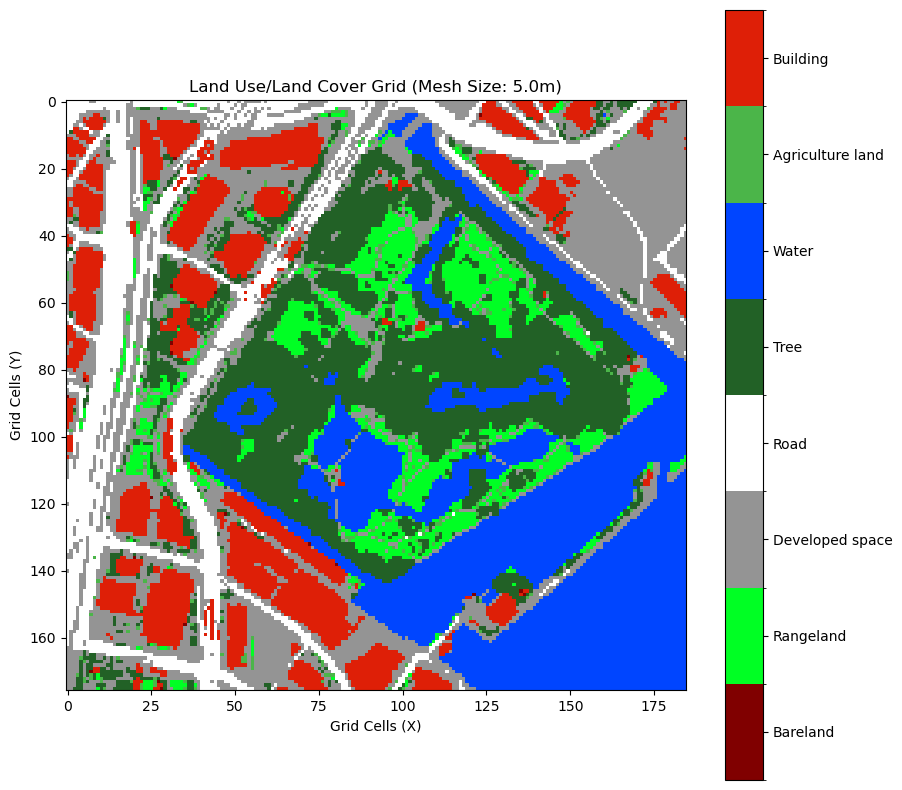


Step 3: Finding LAS files...
Found 144 LAS files
Filtering LAS files by AOI intersection...
Selected 0 / 144 LAS files intersecting AOI


FileNotFoundError: No LAS/LAZ files intersect the specified rectangle.

In [8]:
# Cell: Build canopy grid from OEMJ land cover + Tokyo nDSM (LAS at data/tokyo_las)
import numpy as np

from voxcity.generator import get_land_cover_grid
from voxcity.utils.visualization import get_land_cover_classes
from tokyo_las import (
    get_ndsm_grid,
    align_ndsm_to_landcover,
    build_canopy_from_ndsm,
    fill_canopy_gaps_with_nearest,
    remove_local_spikes_in_canopy,
    summarize_grid,
)

# Define your AOI and mesh size
# rectangle_vertices = [
#     (139.7600, 35.6800),  # lon, lat (SW)
#     (139.7700, 35.6800),  # SE
#     (139.7700, 35.6900),  # NE
#     (139.7600, 35.6900),  # NW
# ]
meshsize = 5.0  # meters
output_dir = "data/temp"

# 1) Land cover (OpenEarthMapJapan)
land_cover_source = "OpenEarthMapJapan"
land_cover_grid = get_land_cover_grid(rectangle_vertices, meshsize, land_cover_source, output_dir)

# Resolve tree and building class IDs robustly for the chosen source
_lc_classes = get_land_cover_classes(land_cover_source)          # {(r,g,b): "ClassName", ...}
_name_to_id = {name: i for i, name in enumerate(_lc_classes.values())}

tree_id = (
    _name_to_id.get("Tree")
    or _name_to_id.get("Trees")
    or _name_to_id.get("Tree Canopy")
    or 4  # fallback commonly used for OEMJ
)

# Prefer explicit name match; avoid "or"-chain ambiguity for index 0
if "Building" in _name_to_id:
    building_id = _name_to_id["Building"]
elif "Buildings" in _name_to_id:
    building_id = _name_to_id["Buildings"]
elif "Building Footprint" in _name_to_id:
    building_id = _name_to_id["Building Footprint"]
else:
    building_id = 1  # reasonable fallback for OEMJ-like schemas

# 2) nDSM from Tokyo LAS (uses las_dir='data/tokyo_las' by default)
#    The grid returned by get_ndsm_grid is north-up; we align to land_cover_grid shape/orientation.
ndsm_grid = get_ndsm_grid(
    rectangle_vertices,
    meshsize,
    source="tokyo_dsm",
    output_dir=output_dir,
    las_dir="data/tokyo_las",  # make sure LAS/LAZ exist here
)
ndsm_aligned, align_info = align_ndsm_to_landcover(
    ndsm_grid,
    land_cover_grid,
    tree_value=tree_id,
    allow_resample=True,
    try_vertical_flip=True,  # will vertical-flip if it improves alignment over tree mask
)
print("Alignment info:", align_info)

# 3) Build initial canopy (nDSM heights only at tree cells; non-tree as NaN)
canopy_height_grid_initial = build_canopy_from_ndsm(
    ndsm_aligned,
    land_cover_grid,
    tree_value=tree_id,
    non_tree_fill=np.nan,
    clamp_negative_to_zero=True,
)

# 4) Fill gaps on tree cells from nearest valid nDSM neighbors (average ties)
canopy_height_grid = fill_canopy_gaps_with_nearest(
    canopy_height_grid_initial,
    ndsm_aligned,
    land_cover_grid,
    tree_value=tree_id,
    treat_zero_as_missing=False,
    restrict_neighbors_to_tree=True,
    allow_resample=False,
    max_neighbor_distance_m=5.0,
    cell_size_m=meshsize,
    fallback_tree_height_m=10.0,
)

# 5) Remove local spikes near buildings and isolated tall trees
canopy_height_grid_spike_free = remove_local_spikes_in_canopy(
    canopy_height_grid,
    land_cover_grid,
    tree_value=tree_id,
    building_value=building_id,
    high_threshold_m=10.0,
    building_buffer_m=15.0,
    cell_size_m=meshsize,
    replacement_tree_height_m=10.0,
)

# 6) Quick summary
summarize_grid("Canopy (filled)", canopy_height_grid)
summarize_grid("Canopy (spike-removed)", canopy_height_grid_spike_free)

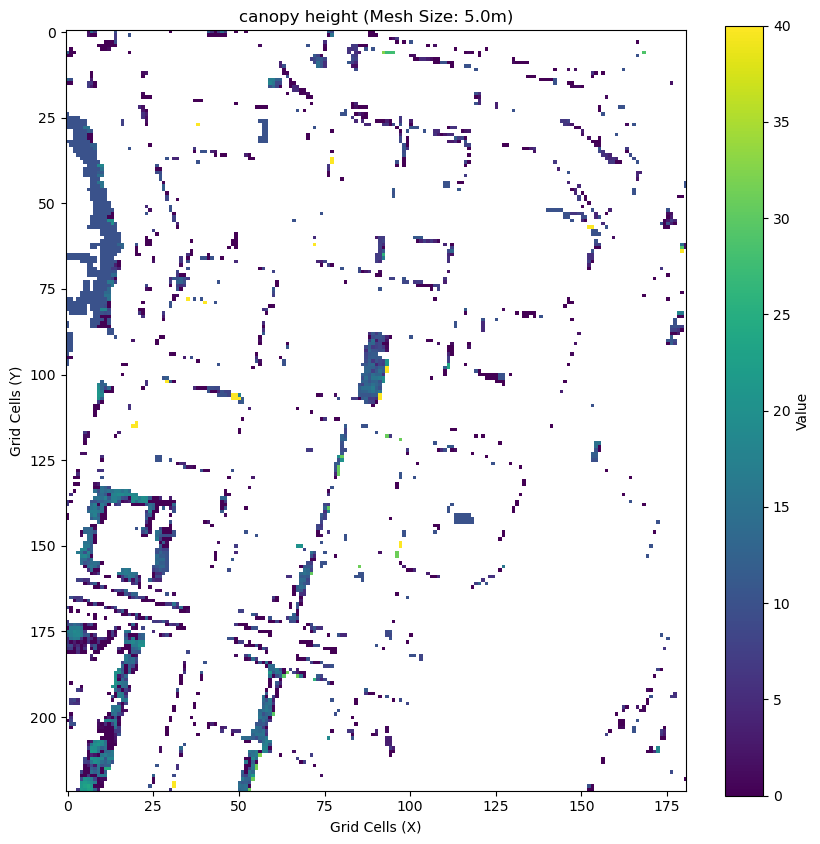

In [2]:
from voxcity.utils.visualization import visualize_numerical_grid_on_basemap, visualize_numerical_grid
import numpy as np

canopy_height_grid[canopy_height_grid == 0] = np.nan
# visualize_numerical_grid_on_basemap(canopy_height_grid, rectangle_vertices, meshsize, vmax=40)
visualize_numerical_grid(np.flipud(canopy_height_grid), meshsize, "canopy height", vmin=0, vmax=40)

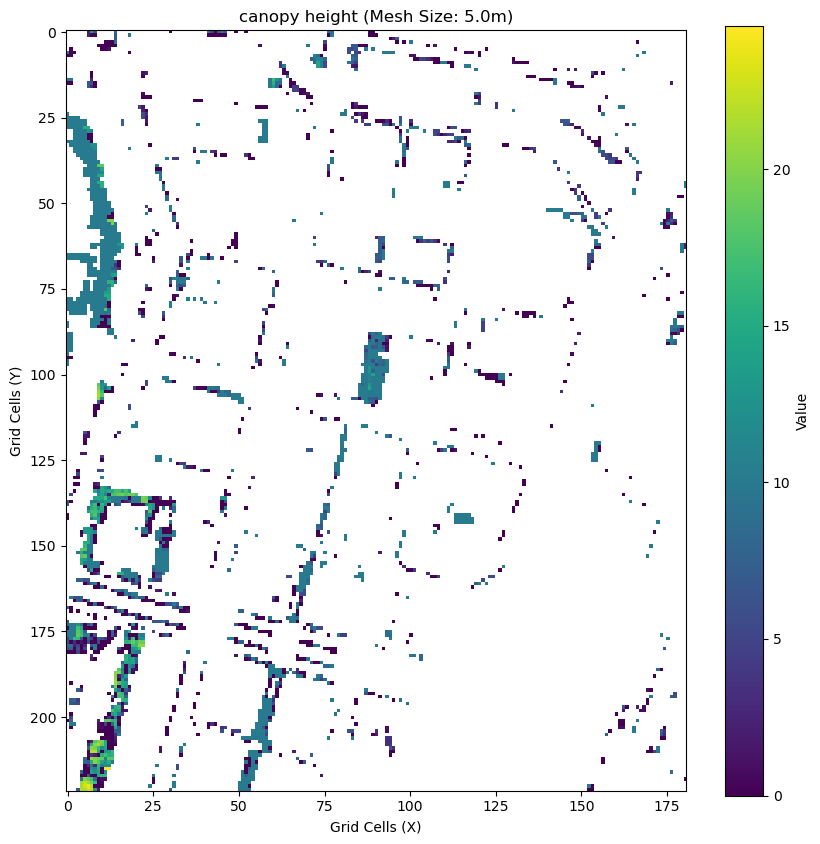

In [3]:
from voxcity.utils.visualization import visualize_numerical_grid_on_basemap, visualize_numerical_grid
import numpy as np

canopy_height_grid_spike_free[canopy_height_grid_spike_free == 0] = np.nan
# visualize_numerical_grid_on_basemap(canopy_height_grid, rectangle_vertices, meshsize, vmax=40)
visualize_numerical_grid(np.flipud(canopy_height_grid_spike_free), meshsize, "canopy height", vmin=0, vmax=None)

In [ ]:
# Jupyter cell: Download all LAS/LAZ ZIPs referenced by Tokyo 23-ku vector tiles
# - Crawls MVT PBF tiles in the given bbox/zooms
# - Extracts any HTTPS links ending with .zip/.laz/.las
# - Downloads concurrently with retries, skipping files that already exist

import os, re, math
from urllib.parse import urlparse
from concurrent.futures import ThreadPoolExecutor, as_completed

import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

# ------------------------------------
# Configuration (adjust as needed)
# ------------------------------------
base_url = "https://gic-tokyo.s3.ap-northeast-1.amazonaws.com/2024/dig/Vectortile/23ku/lp/{z}/{x}/{y}.pbf"

# Approx bounding box for Tokyo 23-ku (WGS84): (min_lat, min_lon, max_lat, max_lon)
bounds = (35.52, 139.56, 35.84, 139.92)

# Try a single high zoom first; increase with [16,17,18] if needed (dedupe prevents duplicates)
zoom_levels = [18]

# Where to save the referenced files (typically ZIPs containing LAS/LAZ)
output_dir = "D:/03_Data/tokyo_las"

# Concurrency and networking
max_workers = 20
connect_timeout_s = 10
read_timeout_s = 60
retries_total = 5
retries_backoff = 1.0

# ------------------------------------
# Helpers
# ------------------------------------
def new_session():
    sess = requests.Session()
    retry = Retry(
        total=retries_total,
        read=retries_total,
        connect=retries_total,
        backoff_factor=retries_backoff,
        status_forcelist=(429, 500, 502, 503, 504),
        allowed_methods=frozenset(["GET", "HEAD"]),
        raise_on_status=False,
    )
    adapter = HTTPAdapter(max_retries=retry, pool_connections=max_workers, pool_maxsize=max_workers)
    sess.mount("http://", adapter)
    sess.mount("https://", adapter)
    return sess

def deg2num(lat_deg, lon_deg, zoom):
    lat_rad = math.radians(lat_deg)
    n = 2.0 ** zoom
    xtile = int((lon_deg + 180.0) / 360.0 * n)
    ytile = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
    return (xtile, ytile)

def pbf_urls_for_bbox(base_url, bounds, zoom):
    min_lat, min_lon, max_lat, max_lon = bounds
    min_x, min_y = deg2num(min_lat, min_lon, zoom)
    max_x, max_y = deg2num(max_lat, max_lon, zoom)
    min_x, max_x = sorted([min_x, max_x])
    min_y, max_y = sorted([min_y, max_y])
    urls = []
    for x in range(min_x, max_x + 1):
        for y in range(min_y, max_y + 1):
            urls.append(base_url.format(z=zoom, x=x, y=y))
    return urls

_zip_re = re.compile(r'https://[^\s"\'<>]+?\.(?:zip|laz|las)(?:\?[^\s"\'<>]*)?', re.IGNORECASE)

def extract_asset_urls_from_pbf_bytes(pbf_bytes):
    # Simple, robust approach: scan text for any LAS/LAZ/ZIP links
    text = pbf_bytes.decode("utf-8", errors="ignore")
    return set(_zip_re.findall(text))

def fetch_pbf_and_extract_urls(session, url):
    try:
        resp = session.get(url, timeout=(connect_timeout_s, read_timeout_s))
        if resp.status_code == 200 and resp.content:
            return extract_asset_urls_from_pbf_bytes(resp.content)
        else:
            print(f"[PBF] {resp.status_code} {url}")
            return set()
    except Exception as e:
        print(f"[PBF] error {url}: {e}")
        return set()

def download_file(session, url, out_dir):
    try:
        os.makedirs(out_dir, exist_ok=True)
        filename = os.path.basename(urlparse(url).path)
        if not filename:
            # Fallback for odd URLs
            filename = re.sub(r'\W+', '_', url)[:100]
        out_path = os.path.join(out_dir, filename)
        tmp_path = out_path + ".part"

        if os.path.exists(out_path) and os.path.getsize(out_path) > 0:
            return (url, "skip-existing", out_path)

        with session.get(url, stream=True, timeout=(connect_timeout_s, read_timeout_s)) as r:
            if r.status_code != 200:
                return (url, f"status-{r.status_code}", None)
            with open(tmp_path, "wb") as f:
                for chunk in r.iter_content(chunk_size=1 << 20):  # 1 MiB
                    if chunk:
                        f.write(chunk)
        os.replace(tmp_path, out_path)
        return (url, "ok", out_path)
    except Exception as e:
        try:
            if os.path.exists(tmp_path):
                os.remove(tmp_path)
        except Exception:
            pass
        return (url, f"error-{e}", None)

# ------------------------------------
# Crawl PBF tiles → collect asset URLs → download
# ------------------------------------
print("Computing PBF tile list...")
all_pbf_urls = []
for z in zoom_levels:
    urls = pbf_urls_for_bbox(base_url, bounds, z)
    print(f" z={z}: {len(urls)} tiles")
    all_pbf_urls.extend(urls)
print(f"Total PBF tiles to fetch: {len(all_pbf_urls)}")

sess = new_session()

print("Fetching PBFs and extracting asset URLs...")
asset_urls = set()
with ThreadPoolExecutor(max_workers=max_workers) as ex:
    futures = [ex.submit(fetch_pbf_and_extract_urls, sess, u) for u in all_pbf_urls]
    for fut in as_completed(futures):
        asset_urls.update(fut.result())

print(f"Unique asset URLs found (.zip/.laz/.las): {len(asset_urls)}")

if not asset_urls:
    print("No asset URLs found. Consider adjusting zoom_levels or bounds.")
else:
    print("Downloading assets...")
    results = []
    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        futures = [ex.submit(download_file, sess, u, output_dir) for u in sorted(asset_urls)]
        for fut in as_completed(futures):
            results.append(fut.result())

    n_ok = sum(1 for _, status, _ in results if status == "ok")
    n_skip = sum(1 for _, status, _ in results if status == "skip-existing")
    n_fail = sum(1 for _, status, _ in results if status not in ("ok", "skip-existing"))
    print(f"Done. ok={n_ok}, skipped={n_skip}, failed={n_fail}")
    if n_fail:
        for url, status, _ in results:
            if status not in ("ok", "skip-existing"):
                print(f"  fail: {status} {url}")

In [1]:
# Cell: Download and extract all Tokyo 23-ku LAS tiles
# - Uses helpers from app/tokyo_las.py
# - Downloads all ZIPs referenced by the vector tiles
# - Extracts into .../data/tokyo_las/<zip_stem>/

import os

# Robust import whether the notebook is run from repo root or app/
try:
    from tokyo_las import download_tiles, extract_all_zips, find_las_files
except ModuleNotFoundError:
    import sys
    sys.path.append(os.path.join(os.getcwd(), "app"))
    from tokyo_las import download_tiles, extract_all_zips, find_las_files

# Vector tile endpoint (given)
base_url = "https://gic-tokyo.s3.ap-northeast-1.amazonaws.com/2024/dig/Vectortile/23ku/lp/{z}/{x}/{y}.pbf"

# Approx bounding box for Tokyo 23-ku (WGS84, order: min_lat, min_lon, max_lat, max_lon)
bounds = (35.52, 139.56, 35.82, 139.93)

# Dataset zoom level
zoom_levels = [16]

# Pick base dir depending on where the notebook runs
if os.path.exists(os.path.join(os.getcwd(), "tokyo_las.py")):
    base_dir = "."
elif os.path.exists(os.path.join(os.getcwd(), "app", "tokyo_las.py")):
    base_dir = "app"
else:
    base_dir = "app"  # default assumption (repo root)

# Where to save ZIPs and extracted LAS/LAZ
zip_dir = "D:/03_Data/tokyo_las"     # ZIPs saved here
# extract_dir = os.path.join(base_dir, "data", "tokyo_las") # Extract under same base dir

os.makedirs(zip_dir, exist_ok=True)
# os.makedirs(extract_dir, exist_ok=True)

print("Step 1: Discovering and downloading LAS ZIPs referenced by vector tiles...")
download_tiles(
    base_url=base_url,
    bounds=bounds,
    zoom_levels=zoom_levels,
    output_dir=zip_dir,
    max_workers=10
)

# print("\nStep 2: Extracting downloaded ZIPs...")
# extract_all_zips(
#     zip_dir=zip_dir,
#     extract_base_dir=extract_dir,
#     max_workers=5
# )

# print("\nStep 3: Verifying extracted LAS/LAZ files...")
# las_files = find_las_files(extract_dir)
# print(f"Found {len(las_files)} LAS/LAZ files under '{extract_dir}'")

Step 1: Discovering and downloading LAS ZIPs referenced by vector tiles...
Target area:
  Latitude range: 35.52 to 35.82
  Longitude range: 139.56 to 139.93
  Width (approx): 33523.76 meters
  Height (approx): 33396.00 meters
Found 4624 PBF tiles to process
Failed to download PBF https://gic-tokyo.s3.ap-northeast-1.amazonaws.com/2024/dig/Vectortile/23ku/lp/16/58174/25776.pbf: 403
Failed to download PBF https://gic-tokyo.s3.ap-northeast-1.amazonaws.com/2024/dig/Vectortile/23ku/lp/16/58174/25777.pbf: 403
Failed to download PBF https://gic-tokyo.s3.ap-northeast-1.amazonaws.com/2024/dig/Vectortile/23ku/lp/16/58174/25779.pbf: 403
Failed to download PBF https://gic-tokyo.s3.ap-northeast-1.amazonaws.com/2024/dig/Vectortile/23ku/lp/16/58174/25775.pbf: 403
Failed to download PBF https://gic-tokyo.s3.ap-northeast-1.amazonaws.com/2024/dig/Vectortile/23ku/lp/16/58174/25778.pbf: 403
Failed to download PBF https://gic-tokyo.s3.ap-northeast-1.amazonaws.com/2024/dig/Vectortile/23ku/lp/16/58174/25783.p